<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/main/LC_FFT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Add the KIC_first_100.csv to the runtime

In [1]:
!pip install lightkurve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 247 kB 22.9 MB/s 
     |████████████████████████████████| 98 kB 9.4 MB/s 
     |████████████████████████████████| 4.5 MB 71.3 MB/s 
     |████████████████████████████████| 41 kB 211 kB/s 
     |████████████████████████████████| 832 kB 53.5 MB/s 
     |████████████████████████████████| 48 kB 6.2 MB/s 
     |████████████████████████████████| 4.1 MB 70.8 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11377 sha256=7823ab14b28e3956b0aaa92a073021b75d38b9d4166fd2b3f1bde539abb3277d
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=2e82a6245a568b4dd654a2e0c9fbcd1c45a6c9c0c5ced233d188747c487fac73
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995d

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import scipy
from scipy.fft import fft, fftfreq
from scipy import signal
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
KOI_first_100 = pd.read_csv('KIC_first_100.csv')
KOI_first_100.drop(KOI_first_100.columns[0], axis=1, inplace=True)
KOI_first_100.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.120,0.140,0.00004,NaN,0.040,-0.070,0.080,-0.020,-0.080,0.080


#FFT

In [15]:
flux = []
time = []
for index, row in KOI_first_100.iterrows():
  search_result_q2 = lk.search_lightcurve('KIC ' + str(row['kepid']), author='Kepler', quarter=2)
  lc = search_result_q2.download()
  lc_flatten = lc.flatten()
  flux_small = lc_flatten['flux'].value
  time_small = lc_flatten['time'].value
  fluxi = np.arange(len(flux_small))
  mask = np.isfinite(flux_small)
  flux_filtered = np.interp(fluxi, fluxi[mask], flux_small[mask])
  sci_flux = abs(fft(flux_filtered))
  sci_freq = scipy.fftpack.fftfreq(flux_small.size, time_small[1]-time_small[0])

  # getting the top 3 dominant frequencies
  f, Pxx = signal.periodogram(flux_filtered)
  top_3periods = {}

  top_freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]

  freqs = f[top_freq_indices]

  powers = Pxx[top_freq_indices]

  periods = 1 / np.array(freqs)

  top_3periods['period1'] = periods[0]
  top_3periods['freq1'] = freqs[0]
  top_3periods['power1'] = powers[0]

  top_3periods['period2'] = periods[1]
  top_3periods['freq2'] = freqs[1]
  top_3periods['power2'] = powers[1]

  top_3periods['period3'] = periods[2]
  top_3periods['freq3'] = freqs[2]
  top_3periods['power3'] = powers[2]

  # removing the sine waves of the dominant frequencies
  Fs = len(time_small)
  sig1 = max(flux_small)*np.sin(2*np.pi*top_3periods['freq1']*time_small)
  sig1_cos = max(flux_small)*np.cos(2*np.pi*top_3periods['freq1']*time_small)
  sig2 = max(flux_small)*np.sin(2*np.pi*top_3periods['freq2']*time_small)
  sig2_cos = max(flux_small)*np.cos(2*np.pi*top_3periods['freq2']*time_small)
  sig3 = max(flux_small)*np.sin(2*np.pi*top_3periods['freq3']*time_small)
  sig3_cos = max(flux_small)*np.cos(2*np.pi*top_3periods['freq3']*time_small)

  flat_flux = np.abs(flux_filtered - sig1 - sig2 - sig3 - sig1_cos - sig2_cos - sig3_cos)

  flux.append(np.array(flat_flux))
  time.append(np.array(time_small))

/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/usr/local/lib/python3.7/dist-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


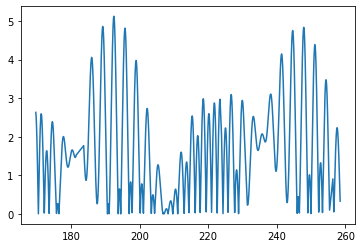

In [12]:
# One of the flux after removing dominant frequencies
flux = np.array(flux)
time = np.array(time)
plt.plot(time[20], flux[20])

In [14]:
df = {'Flux': flux,
      'Time': time,
      'Radius': KOI_first_100['koi_prad']}
df = pd.DataFrame(df)
df

,Flux,Time,Radius
0,"[3.5073894322600054, 3.433361586704594, 3.3592...","[169.76494843763066, 169.78538266266696, 169.8...",2.26
1,"[3.5073894322600054, 3.433361586704594, 3.3592...","[169.76494843763066, 169.78538266266696, 169.8...",2.83
2,"[2.4157249473322544, 2.4289698954119094, 2.441...","[169.76479349768488, 169.78522782353684, 169.8...",14.60
3,"[2.5395905176977847, 2.468886777330029, 2.3994...","[169.76505127520068, 169.7854854336474, 169.80...",2.75
4,"[4.483909801668818, 4.565644563483755, 4.64022...","[169.76481008384144, 169.7852443945594, 169.80...",3.90
...,...,...,...
95,"[1.743313780963921, 1.6832369189014327, 1.6248...","[169.76590756786754, 169.78634167229757, 169.8...",2.11
96,"[1.743313780963921, 1.6832369189014327, 1.6248...","[169.76590756786754, 169.78634167229757, 169.8...",1.46
97,"[2.7545502132889768, 2.754155332098389, 2.7525...","[169.7656909552752, 169.7861252501607, 169.806...",2.44
98,"[1.9854903383246896, 1.989896345286151, 1.9951...","[169.76533741800813, 169.78577189147472, 169.8...",8.99


## Having a problem splitting the DF for CNN training

In [11]:
x, y = df.drop('Radius', axis=1), df['Radius']
x = x.reshape(x.shape[0], x.shape[1], 1)

AttributeError: ignored